# Capstone Project
## Machine Learning Engineer Nanodegree

## Definition

### Project Overview

### Problem Statement
The problem we aim at solving is to find an optimal policy to buy and sell some given stock in order to make profits out of difference between buying price and selling price. We will try to find a solution to this problem through a variety of machine learning approaches. More detail about this can be found in the Analysis section and in particular in the Algorithms and Techniques subsection. We will choose a set of relevant features, on the assumption that their combination might have some predictive power.

In a nutshell, we will be satisfied with the solution if the graph of cumulative profits over time has an upward trending slope and the ratio between the sum of all profits and the sum of all losses is at least greater than 2. This will mean that our model makes twice as much money than it loses, thus ensuring both profitability and low volatility.

### Metrics
* Graph of cumulative profits over time: this shows if the amount cumulative profits made by our agent are a positive amount, how smoothly profits are made with respect to the losses and the downside risk of the periods of negative performance

* Profits minus losses: how much the agent has made minus how much the agent has lost

* Average profit or loss per trade

* Standard deviation of profits and losses

* Percentage of winning trades over all trades (n. of winning trades + n. of losing trades)

* Average profit of winning trades

* Average loss of losing trades

* Drawdowns: amount of money lost from any cumulative peak in the profit curve

    * Worst peak-to-valley drawdown

    * Average drawdown

    * Median drawdown

    * 3rd quartile drawdown

* Recovery time from drawdowns: amount of time it takes to our agent to recover the amount of money previously lost

    * Worst peak-to-valley drawdown recovery time

    * Average drawdown recovery time

    * Median drawdown recovery time

    * 3rd quartile drawdown recovery time

* Risk-adjusted profit or loss measures:

    * Average profit or loss per trade divided by standard deviation of profits and losses

    * Average profit or loss per trade divided by standard deviation of losses only

    * Average profit or loss per trade divided by worst peak-to-valley drawdown

    * Sum of money made of winning trades divided by sum of money lost on losing trades

Our ideal agent:

* makes more money than it loses,

* shows a smooth upward trending profits curve,

* makes high average profits,

* makes low average losses,

* makes high percentage of winning trades,

* makes small drawdowns,

* has short recovery time from drawdowns

## Analysis

### Data Exploration

The dataset consists of financial time series of Apple Inc stock (ticker: AAPL) and comes from Quandl’s open source wiki ([https://www.quandl.com/data/WIKI/AAPL-Apple-Inc-AAPL-Prices-Dividends-Splits-and-Trading-Volume](https://www.quandl.com/data/WIKI/AAPL-Apple-Inc-AAPL-Prices-Dividends-Splits-and-Trading-Volume)). Please find a sample below:

In [22]:
from IPython.display import display

data = pd.read_csv('WIKI-AAPL.csv', index_col=0)

display(data.head())
display(data.tail())

,open,high,low,close,volume,ex_dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
2016-09-06,107.90,108.3000,107.51,107.68,24354375.0,0.0,1.0,107.90,108.3000,107.51,107.68,24354375.0
2016-09-02,107.70,108.0000,106.82,107.73,26802450.0,0.0,1.0,107.70,108.0000,106.82,107.73,26802450.0
2016-09-01,106.14,106.8000,105.62,106.73,26701523.0,0.0,1.0,106.14,106.8000,105.62,106.73,26701523.0
2016-08-31,105.66,106.5699,105.64,106.10,29662406.0,0.0,1.0,105.66,106.5699,105.64,106.10,29662406.0
2016-08-30,105.80,106.5000,105.50,106.00,24863945.0,0.0,1.0,105.80,106.5000,105.50,106.00,24863945.0


,open,high,low,close,volume,ex_dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
1980-12-18,26.63,26.75,26.63,26.63,327900.0,0.0,1.0,0.398490,0.400286,0.398490,0.398490,18362400.0
1980-12-17,25.87,26.00,25.87,25.87,385900.0,0.0,1.0,0.387117,0.389063,0.387117,0.387117,21610400.0
1980-12-16,25.37,25.37,25.25,25.25,472000.0,0.0,1.0,0.379635,0.379635,0.377840,0.377840,26432000.0
1980-12-15,27.38,27.38,27.25,27.25,785200.0,0.0,1.0,0.409713,0.409713,0.407768,0.407768,43971200.0
1980-12-12,28.75,28.87,28.75,28.75,2093900.0,0.0,1.0,0.430213,0.432009,0.430213,0.430213,117258400.0






Along with its daily timestamp as row index, each row contains the following inputs:

* Open: price at which the stock was traded when market opened

* High: highest price at which the stock was traded during the day

* Low: lowest price at which the stock was traded during the day

* Close: price at which the stock was traded when market closed

* Volume: number of stocks traded during the day

* Dividends: amount of money paid by Apple to its stockholders per share

* Splits: see note below

* Split/dividend adjusted open: see note below

* Split/dividend adjusted high: see note below

* Split/dividend adjusted low: see note below

* Split/dividend adjusted close: see note below

* Split/dividend adjusted volume: see note below

(write note explaining split/dividend adjusted price)

For an additional intuitive explanation of how this work, please watch the following video from Udacity’s Machine Learning for Trading course: [https://youtu.be/M2res0zhqjo](https://youtu.be/M2res0zhqjo)

The data per se - as it is given - offers little useful information until it has been preprocessed in order to extract relevant information out of the given data. We postpone documenting such preprocessing steps to the Methodology section.

The only useful information contained in the raw data is the adjusted volume. From now on, we will just refer to it as volume instead of adjusted volume in that it is the only data regarding volume that we are interested in.

The reason why we are interested in volume data is that our fundamental assumption is that price changes are driven by supply and demand and the number of stocks traded indicates whether the price changes are due to a handful of players or to a much larger crowd.

For example, let’s imagine a market where there are very few buyers and sellers. Then, the price will be determined by the supply and demand of those few players. On the contrary, if the crowd trading some market is very large, the equilibrium price will be the result of much wider negotiations. Therefore, we tend to assume that large volumes contribute to more reliable buying and selling signals. In any case, the size of the market - i.e. the number of stocks traded - does matter and we will try to use it to predict price movements, together with other human-engineered features.

Here are a few observations regarding the volume statistics:

* There are 9011 data points, one per trading day from 1980-12-12 to 2016-09-06

* The mean volume is about 91 mln and the median volume is about 63 mln

* The standard deviation of the volume is about 88 mln, which looks pretty high

* The skewness is above 3, which looks high too. We can also notice that the mean is much higher than the median. This suggests us that there are some large outliers on the right side of the distribution.

* The kurtosis is above 28, which is a very high reading. This indicates the tails of the distribution are quite fat.

* The minimum volume was around 250k on 1985-09-27, so during the 80s

* The maximum volume was around 1.9bn (!) on 2000-09-29, during the tech bubble

* There are 616 outliers and 191 major outliers. That is respectively 6.8% and 2.1% of the observations, which looks high. Also, given the outlier lower bound is negative, we infer that all outliers are on the right side of the distribution, since it is not possible the number of stocks traded on some given day is below zero. This tells us there were several days of extraordinary activity in the trading of Apple stocks and it is certainly something to keep in mind.

In [30]:
def summary(df):
    '''Provide summary of relevant statistics for some given feature'''
    
    df = df.iloc[:,0]
    n_obs = df.count()
    mean = df.mean()
    median = df.median()
    std = df.std()
    skew = df.skew()
    kurt = df.kurt()
    min = df.min()
    argmin = df.argmin()
    max = df.max()
    argmax = df.argmax()
    q3, q1 = np.percentile(df.dropna(), [75, 25])
    iqr = q3 - q1
    outlier_lb = q1 - iqr * 1.5
    outlier_ub = q3 + iqr * 1.5
    major_outlier_lb = q1 - iqr * 3
    major_outlier_ub = q3 + iqr * 3
    is_outlier = (df.dropna() < outlier_lb) | (df.dropna() > outlier_ub)
    is_major_outlier = (df.dropna() < major_outlier_lb) | \
                       (df.dropna() > major_outlier_ub) 
    n_outliers = is_outlier.sum()
    n_major_outliers = is_major_outlier.sum()
    n_minor_outliers = n_outliers - n_major_outliers

    values = [mean, median, std, skew, kurt, min, argmin, max, argmax, q1, q3,
              iqr, outlier_lb, outlier_ub, major_outlier_lb, major_outlier_ub,
              n_obs, n_outliers, n_major_outliers, n_minor_outliers] 

    labels = ['mean', 'median', 'std', 'skew', 'kurt', 'min', 'argmin', 'max',
              'argmax', 'q1', 'q3', 'iqr', 'outlier_lb', 'outlier_ub',
              'major_outlier_lb', 'major_outlier_ub', 'n_obs', 'n_outliers',
              'n_major_outliers', 'n_minor_outliers']

    summary = pd.DataFrame(values, labels, ['value'])

    return summary

volumes = data['adj_volume']
summary(pd.DataFrame(volumes))

,value
mean,9.11281e+07
median,6.34424e+07
std,8.79905e+07
skew,3.38451
kurt,28.3175
min,250376
argmin,1985-09-27
max,1.85541e+09
argmax,2000-09-29
q1,3.65582e+07


### Exploratory Visualization

As we can see from the box-and-whisker plot below there are many outliers and some of them are completely elsewhere with respect to the rest of the sample.  This confirms the impression we got in the Data Exploration subsection.

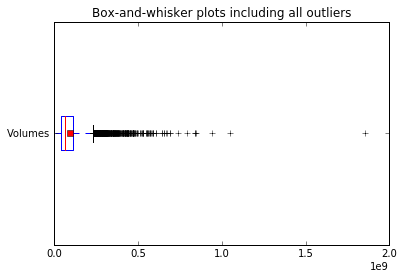

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

# showing all outliers
plt.boxplot(volumes, vert=False, labels=['Volumes'], showmeans=True)
plt.title('Box-and-whisker plots including all outliers')
plt.show()

The plot changes substantially when we remove all major outliers from the picture, i.e. all outliers below Q1 - IQR \* 3 and above Q3 + IQR \* 3.

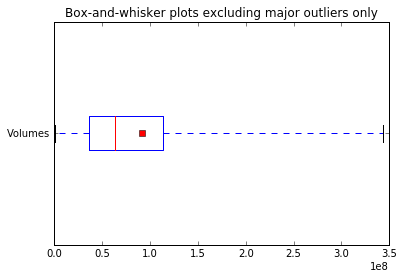

In [32]:
# ignoring major outliers only
plt.boxplot(volumes, vert=False, labels=['Volumes'], showmeans=True,
            showfliers=False, whis=3)
plt.title('Box-and-whisker plots excluding major outliers only')
plt.show()

Eventually, the plot changes even more when we remove all outliers - both major and minor - from the picture, i.e. all outliers below Q1 - IQR \* 1.5 and above Q3 + IQR \* 1.5.

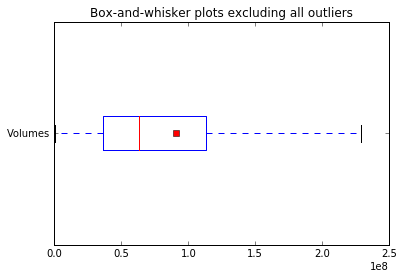

In [33]:
# ignoring all outliers
plt.boxplot(volumes, vert=False, labels=['Volumes'], showmeans=True,
            showfliers=False)
plt.title('Box-and-whisker plots excluding all outliers')
plt.show()

Such visualization gives us a visual intuition of what we observed about outliers in the Data Exploration subsection. The number of outliers is high and this will have to be taken into consideration when building the model.

Then, visualizing the histogram in order to get a visual intuition of the distribution of our volume data confirms what we observed in the Data Exploration subsection. The distribution is clearly positively skewed and it has a very long right tail. Also, it seems the distribution could be approximated by a lognormal distribution.

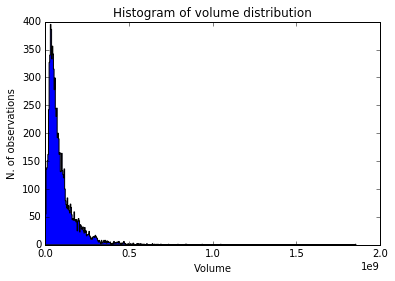

In [34]:
# histogram of volume distribution
plt.hist(volumes, bins=500, histtype='stepfilled')
plt.xlabel('Volume')
plt.ylabel('N. of observations')
plt.title('Histogram of volume distribution')
plt.show()

This is confirmed by the fact that if we do the same plot using the natural logarithm of the data we have a relatively nice bell-shaped curve. We will keep this in mind and see if it is of any help for the rest of the project.

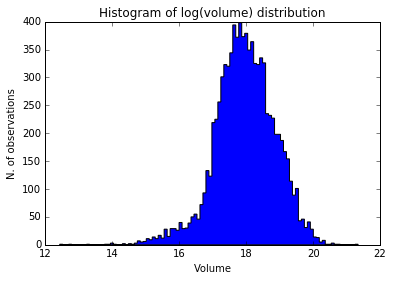

In [35]:
# histogram of log(volume) distribution
plt.hist(np.log(volumes), bins=100, histtype='stepfilled')
plt.xlabel('Volume')
plt.ylabel('N. of observations')
plt.title('Histogram of log(volume) distribution')
plt.show()

### Algorithms and Techniques

Algorithms we will use:
* Q-learning
* Logistic regression
* Support vector machines
* Nearest neighbors classification
* Ensemble learning

There exist countless more machine learning algorithms but for the sake of this project we had to choose a few. Our arbitrary choice fell on this shortlist for a couple of reason: simplicity and diversity. As far as simplicity is concerned, we believe the simpler the model the more chances it has to work. This is often true both in science and in finance. As far as diversity is concerned, we choose a mix of reinforcement learning (e.g. Q-learning) and supervised learning algorithms, making sure we would pick both parametric (e.g. logistic regression) and non-parametric models (e.g. SVMs, KNN). We did not include any unsupervised learning method in that the nature of our  problem is such that we are in possession of the labels for all training sets.

#### General note on cross-validation for all algorithms
Given the nature of our data, our choice will be to train our models on some given subset of the whole dataset at regular intervals (training set) and test its outcome on some immediately subsequent unseen subset (test set). This is known as roll forward cross validation. Its rationale is that learning some model on the whole dataset is more prone to overfitting than learning some model multiple times on small subsets of the data, thus enabling to run multiple tests with the same data.

The reason why this rolling window or roll forward cross validation is a common practice in the case of financial time series is that we really do not want to look into the future while training some model. Hence, it is of utmost importance that the training sets always precede their respective test set.

#### Q-learning
We will define:
* A state consisting of some set of inputs that I will describe in further detail in the Methodology section
* A set of actions (buy, sell, do nothing)
* A set of rewards for all combinations of starting state, action and arrival state
* A model of transitions learned from the training sets

The reason for using Q-learning is to create an agent which learns the rewards and penalties associated with each state and acts on the test set based on the Q-table it learned from the training set. The metaphor we may use is that of a self-driving car which gets rewarded for driving safely and penalized for crashing, causing damages to people or things, and breaking traffic rules. Accordingly, we will reward our agent when it makes money and penalize it when it loses money.

#### Logistic regression
The reason for using logistic regression is to classify the data points to determine whether the the stock should be bought or sold. We will train the model on the training sets based on the human-engineered features discussed in the Methodology section.

For each data point, we will assign some probability of profiting by buying and some probability of profiting by selling based on whether buying or selling the stock would have made a profit or loss. Eventually, we will label data points in the training set by using a sigmoid function and choosing some minimum threshold in order to classify data points in the ‘buy’ class or in the ‘sell’ class and put all other data points in the ‘do nothing’ class.

#### Support vector machines
The reason for using support vector machines is again to classify the data points to determine whether the stock should be bought or sold. The purpose is the same as logistic regression but we use a different approach here: we aim at finding a decision boundary that maximizes the margin, i.e. finding a line or hyperplane that is consistent with the data while committing the least to it. The reason why we want to commit the least to our data is that we want to avoid overfitting.

Since it is possible that our data is not linearly separable given our human-engineered features, we will consider using the kernel trick, i.e. we will use some function to add some features by applying some linear transformation to our own features so that our non-linearly separable data becomes linearly separable. This is necessary with SVMs in that this algorithm puts first and foremost correct classification and only after it maximizes the margin. We will also play with the C and gamma parameters in order to find a model that fits the training data well enough but without falling into the trap of overfitting.

#### Nearest neighbors classification
The reason for using neighbors-based classification is again to classify the data points to determine whether the stock should be bought or sold, but also to diversify the classification approach we will use with logistic regression and support vector machines. By using this algorithm, we do not attempt to construct a general internal model, but simply store instances of the training data and classify via a simple majority vote of the nearest neighbors of each point.

We will try both the basic uniform weighting and the distance-based weighting. In the case of uniform weighting, the value assigned to a query point will be computed from a simple majority vote of the nearest neighbors. In the case of distance-based weighting, we will weight the neighbors such that nearer neighbors contribute more to the fit.

#### Ensemble learning
The reason for using a ensemble learning is to combine the predictions of all other learning algorithm in order to improve generalizability / robustness over a single estimator. Since all learning algortihms have advantages and disadvantages that often differ from each other, by building several estimators independently and averaging their predictions we aim at having a combined estimator such that its variance is lower than that of any other single base estimator.

The way we will apply this averaging method to our problem is to build one portfolio made up of all models. Each model will have equal weight and will perform the action suggested by the outcome of its respective training: buy, sell or do nothing.

Example: Given a portfolio of 100\$ and 4 models A, B, C and D, if model A and B say 'buy', model C says 'sell' and model D says 'do nothing', our ensemble model will suggest to buy 50\$ of Apple stock due to A and B's recommendation, sell 25\$ of Apple stock due to C's recommendation and do nothing with the remaining 25\$ due to D's recommendation. Eventually, the 50\$ of buying and the 25\$ of selling will partially offset each other, resulting in 25\$ of buying only. The clear consequence is that by listening to the opinion of four different learning algorithms the variability of the returns is reduced.

### Benchmark
A common practice in the domain of finance is to consider the performance you would have gotten by just buying the stock at the beginning of the period you are examining and holding it until the end. In our case, we will use the metrics we have listed in the Definition section and see how our models fare against these.

In order to be able to use our metrics for benchmarking purposes, we had to do some preprocessing on our data. We leave the discussion on our preprocessing steps to the Methodology section.

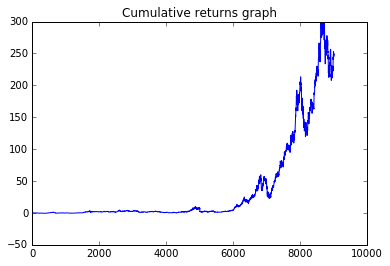

In [36]:
data = data[['adj_close', 'adj_volume']]
data = data.reindex(index=data.index[::-1])

daily_returns = data['adj_close'] / data['adj_close'].shift(1) - 1
daily_returns = pd.DataFrame(daily_returns)
daily_returns.columns = ['daily_returns']
data = data.join(daily_returns)

cumulative_returns = data['adj_close'] / data['adj_close'][0] - 1
cumulative_returns = pd.DataFrame(cumulative_returns)
cumulative_returns.columns = ['cumulative_returns']
data = data.join(cumulative_returns)

# plot line chart of cumulative returns
# remember to put dates on x axis
plt.plot(data['cumulative_returns'].values)
plt.title('Cumulative returns graph')
plt.show()

In [37]:
# for every dollar invested in Apple stock on 12th Dec 1980 (beginning of the
# period), you would made a profit of 249.29$
final_pnl = data['cumulative_returns'][-1]

# avg annual return = avg daily return * number of trading days in a year
avg_annual_return = data['daily_returns'].mean() * 252

# avg annual std = daily std * sqrt(number of trading days in a year)
# we take the sqrt because
# std = sqrt(variance)
# annual variance = daily variance * 252
# annual std = sqrt(annual variance)
#            = sqrt(daily variance * 252)
#            = sqrt(daily variance) * sqrt(252)
#            = daily std * sqrt(252)
annual_std = data['daily_returns'].std() * np.sqrt(252)

cum_ret = data['cumulative_returns']
drawdowns = np.maximum.accumulate(cum_ret) - cum_ret
max_drawdown_valley = np.argmax(drawdowns)
max_drawdown_peak = np.argmax(cum_ret[:max_drawdown_valley])

max_drawdown = np.max(drawdowns)
avg_drawdown = np.mean(drawdowns)
median_drawdown = np.median(drawdowns)
q3_drawdown = np.percentile(drawdowns, 75)

# remember to compute recovery time from drawdowns

# risk-adjusted return measures
# all such measures are annualized here
# information ratio = sharpe ratio without taking risk-free rate into account
# using Narang's definition here, not Balch's - hence ignoring beta
information_ratio = avg_annual_return / annual_std

# sterling ratio = avg return / std of below average returns
below_avg_returns = daily_returns[daily_returns < daily_returns.mean()]
annual_below_avg_returns_std = below_avg_returns.std() * np.sqrt(252)
sterling_ratio = avg_annual_return / annual_below_avg_returns_std
sterling_ratio = sterling_ratio.values[0]

# adjusted sterling ratio = avg return / std of negative returns
negative_returns = daily_returns[daily_returns < 0]
annual_negative_returns_std = negative_returns.std() * np.sqrt(252)
adjusted_sterling_ratio = avg_annual_return / annual_negative_returns_std
adjusted_sterling_ratio = adjusted_sterling_ratio.values[0] 

calmar_ratio = avg_annual_return / max_drawdown

# omega ratio = sum of all positive returns / sum of all negative returns
positive_returns = daily_returns[daily_returns > 0]
omega_ratio = positive_returns.sum() / negative_returns.sum().abs()
omega_ratio = omega_ratio.values[0]

metrics_values = [final_pnl, avg_annual_return, annual_std, max_drawdown,
                  avg_drawdown, median_drawdown, information_ratio,
                  sterling_ratio, adjusted_sterling_ratio, calmar_ratio,
                  omega_ratio]

metrics_labels = ['final_pnl', 'avg_annual_return', 'annual_std', 'max_drawdown',
                  'avg_drawdown', 'median_drawdown', 'information_ratio',
                  'sterling_ratio', 'adjusted_sterling_ratio', 'calmar_ratio',
                  'omega_ratio']

metrics = pd.DataFrame(metrics_values, metrics_labels, ['benchmark'])

display(metrics)

,benchmark
final_pnl,249.294356
avg_annual_return,0.266496
annual_std,0.469047
max_drawdown,93.885701
avg_drawdown,8.065995
median_drawdown,2.314381
information_ratio,0.568165
sterling_ratio,0.801082
adjusted_sterling_ratio,0.796429
calmar_ratio,0.002839


Among these values, the ones that matter the most to us are the information ratio, the adjusted Sterling ratio and the Omega ratio.

The information ratio matters in that it divides the average annual return by the annual standard deviation. In this particular case, we can see the importance of it since we have a high annual return - almost 27% - but even higher standard deviation, which gives us an idea of the risk we took in order to get the reward we got. Therefore, dividing the average return by the standard deviation of the returns seems to be a sound way to measure risk-adjusted returns. Ideally, we would like to have an information ratio greater than 2 for our model.

The adjusted Sterling ratio is quite similar to the information ratio but it differs from it by diving the average annual return by the annual standard deviation of the losses only, which is interesting in that we might not care about the standard deviation as long it goes in our favour.

The omega ratio also matters since it divides the amount of money we made when we won by the amount of money we lost. For our model, we would be happy to have an omega ratio greater than 3.

## Methodology

### Data Preprocessing
As we anticipated in earlier sections, our data require a few preprocessing steps in that the raw data per se contains very little. However, there is a lot more information we can extract by applying some feature transformation to our raw data. We shall list the preprocessing steps we put in place in order to ease the process of handling our data and squeeze relevant information out of it:

* Keep only adj_close and adj_volume, remove all other useless columns. All the information needed is contained by the selcted columns.

* Reverse order from-most-recent-to-least-recent (Z -> A) to from-least-recent-to-most-recent (A -> Z).This will ease data handling due to the roll forward cross validation we chose and discussed about in our Analysis section, in the Algorithms and Techniques subsection.

* Compute daily returns. How much the stock price changed with respect to the previous day since the variation of the price tells a lot more than the price per se.

* Compute cumulative returns. How much the stock price changed with respect to the beginning of the period. This defines how much we would have made or lost (in percentage) by owning the stock at time t given we bought it at the beginning of the period.

* Compute momentum. How much the stock price has changed over some number of days. This measures the steepness of the cumulative returns line over some number of days.

* Compute momentum * volume. Scale momentum by volume so that trading days with more transactions acquire more weight than trading days with less transactions.

* Normalize all features. Scale all values so that all observations are between zero and one for learning algorithms requiring features scaling such as support vector machines.

* Remove outliers. Keep only data points that could be considered 'normal' market conditions.

This last point is directly related with the abnormalities we observed in our Data Exploration section regarding the high number of outliers. Now that we have our new human-engineered features, we shall perform some additional data exploration on these in order to verify whether we can get some insight on the data by looking at their distribution. In particular, we aim at spotting outliers in order to consider removing abnormalities from our dataset.

In [58]:
# compute momentum human-engineered feature
momentum = data['adj_close'] / data['adj_close'].shift(5) - 1
momentum = pd.DataFrame(momentum)
momentum.columns = ['momentum']

In [39]:
# Scale all values so that all observations are between zero and one for learning
# algorithms requiring features scaling such as support vector machines.

from sklearn import preprocessing

# scale momentum
# use MinMax scaler from sklearn
minmax_scaler = preprocessing.MinMaxScaler()

# scale abs(momentum)
# then multiply scaled values by sign(momentum) so that scaled values have same
# sign as non-scaled values
momentum_dropna = momentum.dropna()
scaled_momentum = minmax_scaler.fit_transform(abs(momentum_dropna)) * \
                  np.sign(momentum_dropna)
# scale volumes
scaled_volumes = minmax_scaler.fit_transform(volumes)
# scale momentum_by_volume
scaled_momentum_by_volume = \
minmax_scaler.fit_transform(momentum_by_volume.dropna()) 

In [62]:
momentum_by_volume = momentum * volumes.values
momentum_by_volume.columns = ['momentum_by_volume']
data = data.join(momentum_by_volume)

### Data Exploration on Preprocessed Data

#### Daily returns

In [40]:
display(summary(daily_returns))

,value
mean,0.00105752
median,0
std,0.0295472
skew,-0.36725
kurt,17.3225
min,-0.518692
argmin,2000-09-29
max,0.332152
argmax,1997-08-06
q1,-0.0141654


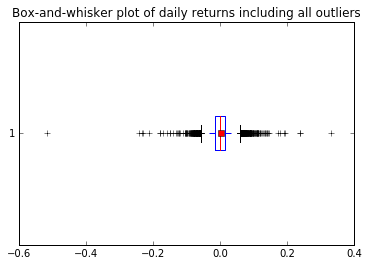

In [41]:
plt.boxplot(data['daily_returns'].dropna().values,
            vert=False,
            showmeans=True)
plt.title('Box-and-whisker plot of daily returns including all outliers')
plt.show()

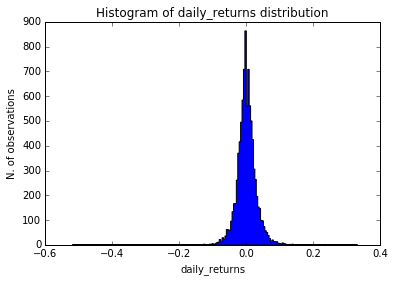

In [42]:
plt.hist(data['daily_returns'].dropna().values, bins=200, histtype='stepfilled')
plt.xlabel('daily_returns')
plt.ylabel('N. of observations')
plt.title('Histogram of daily_returns distribution')
plt.show()

#### Momentum

In [43]:
display(summary(momentum))

,value
mean,0.00532682
median,0.00444939
std,0.0661299
skew,0.044609
kurt,6.21376
min,-0.587664
argmin,2000-10-05
max,0.668
argmax,1997-08-07
q1,-0.0315922


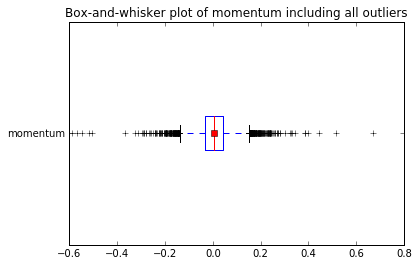

In [44]:
plt.boxplot(momentum.dropna().values,
            vert=False,
            labels=['momentum'],
            showmeans=True)
plt.title('Box-and-whisker plot of momentum including all outliers')
plt.show()

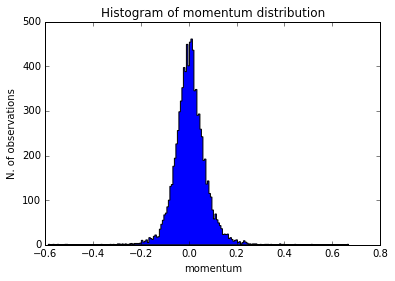

In [45]:
plt.hist(momentum.dropna().values, bins=200, histtype='stepfilled')
plt.xlabel('momentum')
plt.ylabel('N. of observations')
plt.title('Histogram of momentum distribution')
plt.show()

It can be observed that daily returns and momentum distributions share a similar distribution. Both have their mean centered around 0, both have relatively long tails due to the distance of major outliers from the mean and both have a quite simmetrical shape, except that the daily returns is slightly negatively skewed whereas the momentum distribution is very slightly positively skewed.

The similarities should not surprise us in that both features share a similar nature: daily returns tell us the percent change in the stock price from the previous day, while momentum tells us the percent change in the stock price over the last 5 trading days. What we can observe by the difference in skewness is that some violent negative returns make the left tail longer and consequently the skewness negative, but such violent negative daily returns tend to be recovered over a slightly longer 5-day term.

#### Momentum weighted by volume

In [46]:
display(summary(momentum_by_volume))

,value
mean,607846
median,166865
std,1.81644e+07
skew,-8.97604
kurt,1069.09
min,-9.3997e+08
argmin,2000-09-29
max,6.27158e+08
argmax,1997-08-07
q1,-1.54451e+06


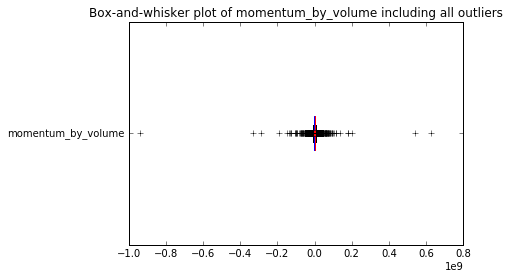

In [47]:
plt.boxplot(momentum_by_volume.dropna().values,
            vert=False,
            labels=['momentum_by_volume'],
            showmeans=True)
plt.title('Box-and-whisker plot of momentum_by_volume including all outliers')
plt.show()

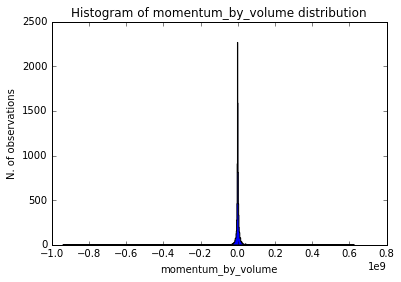

In [48]:
plt.hist(momentum_by_volume.dropna().values, bins=1000, histtype='stepfilled')
plt.xlabel('momentum_by_volume')
plt.ylabel('N. of observations')
plt.title('Histogram of momentum_by_volume distribution')
plt.show()

In [ ]:
mome

In the case of the momentum by volume distribution we can observe the number of outliers is very high, thus making the tail of our distribution very long. Interestingly, while the momentum skewness is slightly positive and the volume skewness is clearly positive, the momentum by volume skewness is very negative. This shows how violent price declines are a lot more frequent than violent price increases, confirming the saying according to which the market goes up by the stairs and down by the elevator.

It should also be noted that the number of outliers is a lot higher for the momentum by volume feature than for other features. This might be explained by the fact that the multiplication of two existing features results in larger values at the extremes, thus increasing the number of outliers. We will keep this in mind when we decide which data points to keep in our training sets based on whether we decide to consider them an outlier or not.

#### Scatter matrix

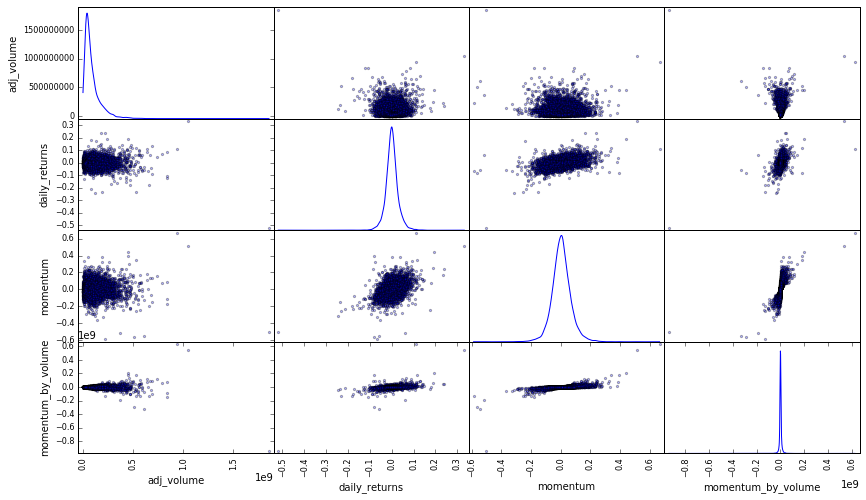

In [66]:
data_subset = data.loc[:, ['adj_volume',
                           'daily_returns',
                           'momentum',
                           'momentum_by_volume']] 

pd.scatter_matrix(data_subset, alpha = 0.3, figsize = (14,8), diagonal = 'kde')
plt.show()

The scatter matrix above enables us to look for potential correlations among features.

The correlations between momentum and momentum_by_volume and between adj_volume and momentum_by_volume should be ignored since momentum_by_volume is a linear combination of momentum and adj_volume.

There appears to be some correlation between daily_returns and momentum, but it should be noted that - as we pointed out above - daily_returns and momentum share a similar nature: daily returns tell us the percent change in the stock price from the previous day, while momentum tells us the percent change in the stock price over the last 5 trading days. Hence, daily_returns values contribute to determine momentum values.

Moreover, the nature of our problem is such that it is of no use to know that daily_returns and some other feature are correlated at time t. Instead, what we need to know is whether the information we have at time t is enough to predict if the daily_returns value will be positive or negative at time t + delta. For example, we would like to know if there is some correlation between momentum_by_volume and daily_returns at time t + 1:

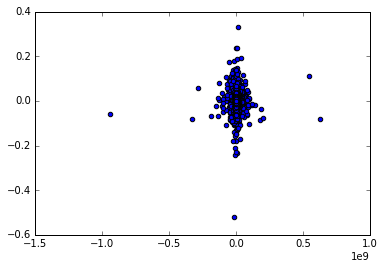

In [69]:
plt.scatter(momentum_by_volume, daily_returns.shift(-1)) 
plt.show()

From the scatter above, we can notice than it it becomes harder to see some immediately recognizable correlation when we look at the daily_returns at time t + 1 instead of those at time t.

#### Outliers removal

Now that we have performed some exploratory analysis on our new human-engineered features, we shall create 3 different datasets to test our models on: one dataset with no outliers, one with no major outliers and one with all outliers. We will test our models on each of these 3 dataset and see if there are significant differences in performance based on the dataset.

In [71]:
def remove_outliers(df, coeff=1.5):

    result = pd.DataFrame(index=df.index)
    columns = range(0, df.shape[1])

    for i in columns:
        column = df[[i]].dropna()
        q3, q1 = np.percentile(column, [75, 25])
        iqr = q3 - q1
        outlier_lb = q1 - iqr * coeff
        outlier_ub = q3 + iqr * coeff
        is_not_outlier = (column > outlier_lb) & (column < outlier_ub)
        result = result.join(column[is_not_outlier])

    return result.dropna()

Before we proceed with removing outliers, we shall subset the portion of data we want to consider in order to take outliers away.

For example, it would not make any sense to remove datapoints from the dataset based on the fact their adj_close is an outlier because the stock price has varied extensively over time - which is a normal behaviour for a stock price - and we do not see any point in removing datapoints just because they are too far from their historical median. If we removed datapoints on this criterion, we would leave out of our dataset all most recent point since the Apple stock had massive growth over the last few years.

In [84]:
# show last datapoints in dataset
display(data[['adj_close']].tail())

,adj_close
2016-08-30,106.00
2016-08-31,106.10
2016-09-01,106.73
2016-09-02,107.73
2016-09-06,107.68


In [83]:
# show last datapoints in dataset if outliers are taken away based on adj_close
display(remove_outliers(data[['adj_close']]).tail())

,adj_close
2010-03-31,30.737161
2010-04-01,30.864034
2010-04-05,31.193641
2010-05-07,30.849646
2010-05-20,31.098160


From the table above, we can see that all datapoints after 2010-05-20 would have been taken away, thus depriving us of the most recent datapoints without a sound reason. Due to the common nature of adj_close and cumulative_returns, the same reasoning applies to cumulative_returns.

In [87]:
# show last datapoints in dataset if outliers are taken away based on cumulative_returns
display(remove_outliers(data[['cumulative_returns']]).tail())

,cumulative_returns
2010-03-31,70.446304
2010-04-01,70.741210
2010-04-05,71.507358
2010-05-07,70.707767
2010-05-20,71.285418


Also, we already noticed in the Data Exploration on Preprocessed Data subsection that the number of outliers is a lot higher for the momentum_by_volume feature than for other features. We pointed out that this might be explained by the fact that the multiplication of two existing features results in larger values at the extremes, thus increasing the number of outliers.

In [108]:
# show number of outliers per feature by subtracting number of outliers from number of observations
print "n. of outliers: {}".format(data[['momentum']].count() -
                                  remove_outliers(data[['momentum']]).count())
print "n. of outliers: {}".format(data[['adj_volume']].count() -
                                  remove_outliers(data[['adj_volume']]).count())
print "n. of outliers: {}".format(data[['momentum_by_volume']].count() -
                                  remove_outliers(data[['momentum_by_volume']]).count())

n. of outliers: momentum    338
dtype: int64
n. of outliers: adj_volume    616
dtype: int64
n. of outliers: momentum_by_volume    1481
dtype: int64


We consider that the number of momentum_by_volume outliers is artificially high due to the fact that the multiplication of two existing features results in larger values at the extremes. Consequently, we will choose not to consider  momentum_by_volume to determine datapoints to exclude from our datasets in that it is linear combination of two other features (momentum and volume) and we consider the information contained in momentum and volume is enough to spot outliers accurately.

Therefore, the features we will take into account to determine outliers are adj_volume, momentum and daily_returns.

In [144]:
# subset features to determine outliers
subset = data[['adj_volume', 'momentum', 'daily_returns']]

# generate indexes to create datasets
no_outliers_ix = remove_outliers(subset).index
no_major_outliers_ix = remove_outliers(subset, 3).index
with_outliers_ix = subset.dropna().index

# create master dataset
dataset = data[['adj_volume',
                'momentum',
                'momentum_by_volume',
                'daily_returns']]

# build dataset based on previously generated indexes
no_outliers = dataset.loc[no_outliers_ix, :]
no_major_outliers = dataset.loc[no_major_outliers_ix, :]
with_outliers = dataset.loc[with_outliers_ix, :]

#### Training set and test set generation
The nature of our problem is such that it is crucial to pay very close attention to how we create our training and test sets as this choice alone could make all our models prone to overfitting. In particular - as Georgia Tech's professor Tucker Balch points out in the Machine Learning for Trading course - we do not want to make the mistake of looking into the future. Therefore, when doing cross-validation - i.e. partitioning the dataset into subdatasets - it  is of utmost importance to make sure that the training set always precedes the test set. This cross-validation method is called roll-forward cross-validation.

The way we have implemented this is through our generate_sets function, which takes as arguments:
- a dataframe of features,
- the size of the training sample (window_size),
- the frequency of re-training the model(step_size).

For example, with window_size=90 and step_size=6, on day 91 we train the model on the subset of our features from day 1 to day 90 and use it to predict days 91 to 96. Then, on day 97 we retrain the model from day 7 to 96 and use to predict days 96 to 101, and so on so forth.

#### Dataset labeling
The way we choose to label our data is to create 3 classes: -1, 0 and 1:
- -1 when the daily return of the following day is negative
- 0 when the daily return of the following day is zero
- 1 when the daily return of the following day is positive

This was done by computing the sign of daily returns and shifting them by -1.

#### Dealing with outliers
When it comes to the choice of how to dela with outliers, we considered several options:
- take them out of the dataset and behave as they did not exist,
- keep them into the dataset but do not trust the model's predicted label if there are too many of them,
- keep them into the dataset but do not trust the model's predicted label even if there is just one them.

Taking them away from the dataset does not seem wise to use since they are part of the dataset and arguably they mean something. Not trusting the model's predicted labels if there is a certain number of outliers in the dataset does not look like a good alternative either in that there are many of them in the dataset, which would decrease greatly the number of trading opportunities and prevent us from receiving potentially useful insight.

For these reasons, we opted for keeping them into the dataset but pruning them by setting them equal to the outlier upper bound when they were on the right side of the distribution and to the lower bound when they were on the left side of distribution. As a result, after scaling all left outliers take the value of 0 and all right outliers take the value of 1. The benefit of such move is that outliers stay in the dataset but do not have the effect of squeezing the bulk of the distribution into an artificially dense area.

#### Feature scaling
Features are scaled using the minmax scaler so that all values are between 0 and 1. The reason for this is that some algorithms - like SVM - would give excessive weight to some features just because of the range of their values is wider than others.

It is interesting to notice that we could not scale the test sets the same way we used with the training sets. With the training sets, we could simply prune the outliers with the function we created. However, if we had done the same with the test sets, the outliers would have been identified based on the data contained in the test set only. This would have been a problem for two reasons:
- the training set and test set would have two different outlier lower and upper bounds - thus two different ranges -  which is not logical since both should have the same lower and upper bounds and range, in order to compare comparables
- computing the lower and upper bound of the test sets would imply that all its values are known at the beginning of the test set period, but this is not the case as only training set values are known at decision making time

For these reasons, it appeared a lot more logical to computer the scaled values of the test set using the lower and upper bound and range of the training set as follows:

    scaled value = (test set value - training set min) / (training set max - training set min)

### Implementation
We created a run_model function that takes as input:
- one model
- a list of training sets
- a list of test sets
- a dataframe of labels

This function:
- iterates over the couples of training and test set,
- fits the model on each training window,
- tests it on the test window,
- compares the predicted outcome versus the actual outcome,within the test window
- computes the profit or loss made on each test example within the test window
- returns a dataframe of accuracy values and a dataframe of profit and loss values over all test windows

The models from sklearn we tested are:
- ```linear_model.LogisticRegression()```
- ```svm.SVC()```
- ```neighbors.KNeighborsClassifier()```


#### Data Preprocessing
- If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?
- Based on the Data Exploration section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?
    - How did you implement your rolling windows?
    - How did you label your training samples?
    - How did you deal with outliers? Why? Have you corrected the left outliers issue?
    - Why did you scale your features? How did you do it?

#### Implementation
- Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?
    - Explain run_model
- Was there any part of the coding process (e.g., writing complicated functions) that should be documented?

#### Refinement

- Has an initial solution been found and clearly reported?
- Is the process of improvement clearly documented, such as what techniques were used?
- Are intermediate and final solutions clearly reported as the process is improved?